In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
dic = pickle.load(open('trainingDataSetSmallHSC_RC2.pkl', 'rb'))
data=pd.DataFrame(dic)

StarID=np.array(data.columns)
star= np.array(data.iloc[0])

dicc= dict(zip(StarID, star))

In [3]:
all_images= np.array(data.iloc[0])
all_images = np.stack(all_images)  # Convertir a un array NumPy 3D: (N, 25, 25)

# Normaliza y agrega canal para PyTorch: (N, 1, 25, 25)
all_images = np.expand_dims(all_images, axis=1)

In [4]:
all_targets = np.array(data.iloc[2])
all_targets = np.stack(all_targets)  # Convertir a un array NumPy 3D: (N, 25, 25)

# Agrega canal para PyTorch: (N, 1, 25, 25)
all_targets = np.expand_dims(all_targets, axis=1)

#Las imágenes ya están normalizadas entre 0 y 1.

In [5]:
print(all_images.shape)
print(all_targets.shape)
print(all_images.dtype)
print(all_targets.dtype)
print(all_images.max(), all_images.min())
print(all_targets.max(), all_targets.min())

(20001, 1, 25, 25)
(20001, 1, 25, 25)
float32
float32
0.5590923 -0.024684794
0.17808317 -0.0028571242


In [6]:
from torch.utils.data import TensorDataset,DataLoader

#Covierte los arreglos a un tensor con tipo de dato float32 para compatibilidad en PyTorch
tensor_images = torch.tensor(all_images, dtype=torch.float32) 
tensor_targets = torch.tensor(all_targets, dtype=torch.float32)

#Conjunto completo de datos
dataset = TensorDataset(tensor_images, tensor_images)


#DataLoader Es una clase de PyTorch que organiza y entrega los datos a tu modelo en mini-lotes.
#El modelo entrena con 32 datos a la vez, y los datos se barajan (shuffle=True) en cada época para mejorar el entrenamiento.  

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)




In [7]:
# Encoder
class Encoder(nn.Module):  # Hereda de nn.Module, la base para todos los modelos en PyTorch
    ''' Clase define la parte codificadora del VAE. 
    Su función es tomar una imagen (25x25 píxeles) y producir una representación comprimida (latente) 
    en el espacio latente definido por mu (media) y logvar (log-varianza).'''
    def __init__(self, latent_dim):  # latent_dim es la dimensión del espacio latente
        super(Encoder, self).__init__()

        # Primera capa totalmente conectada (fully connected)
        # Entrada de tamaño 625 (porque 25x25 = 625 píxeles por imagen)
        # Salida: 256 neuronas
        self.fc1 = nn.Linear(625, 256)

        # Segunda capa: reduce a 128 neuronas
        self.fc2 = nn.Linear(256, 128)

        # Capa para calcular la media (μ) del vector latente
        self.fc_mu = nn.Linear(128, latent_dim)

        # Capa para calcular la log-varianza (log(σ²)) del vector latente
        self.fc_logvar = nn.Linear(128, latent_dim)



    def forward(self, x):
        x = x.view(-1, 625)  # Aplana cada imagen 25x25 a un vector de 625 elementos

        # Paso por la primera capa y se aplica la activación ReLU
        h1 = F.relu(self.fc1(x))

        # Paso por la segunda capa con ReLU nuevamente
        h2 = F.relu(self.fc2(h1))

        # Se generan los vectores de media y log-varianza desde la segunda capa
        mu = self.fc_mu(h2)         # Vector medio (μ) del espacio latente
        logvar = self.fc_logvar(h2) # Vector log-varianza (log(σ²)) del espacio latente

        # Se retorna la media y log-varianza, que luego se usan para la reparametrización
        return mu, logvar


# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        # Capa totalmente conectada que transforma el vector latente en una representación de tamaño 128
        self.fc1 = nn.Linear(latent_dim, 128)
        
        # Segunda capa totalmente conectada que expande a 256 dimensiones
        self.fc2 = nn.Linear(128, 256)
        
        # Última capa que produce una salida de tamaño 625 (que será reconfigurada como imagen 25x25)
        self.fc3 = nn.Linear(256, 625)

    def forward(self, z):
        # Paso del vector latente por la primera capa + activación ReLU
        h1 = F.relu(self.fc1(z))
        
        # Paso por la segunda capa + activación ReLU
        h2 = F.relu(self.fc2(h1))
        
        # Paso por la última capa + activación sigmoide
        # La sigmoide limita la salida entre 0 y 1
        x_hat = torch.sigmoid(self.fc3(h2))
        
        # Reorganiza el vector plano de 625 en un "mini-batch" de imágenes 25x25 con un canal
        return x_hat.view(-1, 1, 25, 25)


# VAE Model
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder  # Red neuronal encargada de comprimir los datos de entrada al espacio latente
        self.decoder = decoder  # Red neuronal encargada de reconstruir los datos a partir del vector latente

    def reparameterize(self, mu, logvar):
        """
        Aplica el truco de reparametrización:
        En vez de muestrear directamente de una distribución (lo cual no es diferenciable),
        se transforma una variable aleatoria normal estándar para que tenga media mu y varianza logvar.
        Esto permite entrenar el modelo usando backpropagation.
        """
        std = torch.exp(0.5 * logvar)        # Calcula la desviación estándar a partir de la varianza logarítmica
        eps = torch.randn_like(std)          # Muestra ruido aleatorio de una normal estándar
        return mu + eps * std                # Retorna la muestra z usando la fórmula: z = mu + std * eps

    def forward(self, x):
        """
        Pasa los datos de entrada x por el modelo completo:
        1. Codifica x a mu y logvar.
        2. Aplica reparametrización para obtener z.
        3. Decodifica z para obtener x_hat (la reconstrucción).
        """
        mu, logvar = self.encoder(x)         # Codifica la entrada y obtiene los parámetros de la distribución latente
        z = self.reparameterize(mu, logvar)  # Aplica el truco de reparametrización para obtener el vector latente z
        x_hat = self.decoder(z)              # Reconstruye la imagen a partir de z
        return x_hat, mu, logvar             # Devuelve la imagen reconstruida y los parámetros del espacio latente


# VAE Loss function
def vae_loss(x_hat, x, mu, logvar):
    # ==========================
    # 1. Reconstrucción
    # ==========================
    # Calcula el error entre la imagen reconstruida (x_hat) y la imagen original (x)
    # Aquí se usa el error cuadrático medio (MSE), sumado en todos los píxeles
    # Si estás usando imágenes normalizadas entre 0 y 1, esto tiene sentido como métrica de calidad
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')

    # ==========================
    # 2. Divergencia KL
    # ==========================
    # Esta parte penaliza que la distribución latente (mu, logvar) se aleje de una normal estándar (media 0, varianza 1)
    # Fórmula: D_KL(N(mu, sigma) || N(0, 1))
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # ==========================
    # 3. Pérdida total = reconstrucción + regularización
    # ==========================
    # La pérdida total busca:
    # - Que la reconstrucción sea buena (recon_loss pequeña)
    # - Que el espacio latente esté regulado (kl_div pequeña)
    return recon_loss + kl_div



In [8]:
# Dimensión del espacio latente (cuántas variables se usan para representar una imagen en el espacio comprimido)
latent_dim = 2

# Dispositivo donde se ejecutará el modelo: en este caso se fuerza el uso de la CPU
device = torch.device("cpu")

# Se crean y envían al dispositivo el encoder, decoder y el VAE completo
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
vae = VAE(encoder, decoder).to(device)

# Se define el optimizador que va a ajustar los pesos del VAE. Aquí se usa Adam con un learning rate pequeño
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-6)

# Número de épocas (veces que se recorre todo el dataset)
num_epochs = 80

# Lista donde se va a guardar la pérdida promedio por cada época (para visualizar después)
loss_per_epoch = []

# Se pone el modelo en modo entrenamiento
vae.train()

# Bucle de entrenamiento principal
for epoch in range(num_epochs):
    total_loss = 0  # Acumulador de pérdida total para la época actual
    
    # Iteramos sobre los mini-batches del conjunto de entrenamiento
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)  # Enviar los datos al dispositivo (CPU)
        
        optimizer.zero_grad()  # Reiniciar los gradientes
        
        # Paso hacia adelante (forward): se obtienen las salidas y parámetros latentes
        x_hat, mu, logvar = vae(x_batch)

        # Se calcula la pérdida del VAE (reconstrucción + regularización KL)
        loss = vae_loss(x_hat, x_batch, mu, logvar)

        # Paso hacia atrás (backward): calcula los gradientes
        loss.backward()

        # Actualiza los pesos del modelo con los gradientes calculados
        optimizer.step()

        # Acumular la pérdida de este batch
        total_loss += loss.item()
    
    # Calcular la pérdida promedio en la época
    avg_loss = total_loss / len(train_loader.dataset)

    # Guardar la pérdida promedio para poder graficarla luego si se desea
    loss_per_epoch.append(avg_loss)

    # Imprimir progreso
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")





Epoch 1, Loss: 153.397945
Epoch 2, Loss: 149.615578
Epoch 3, Loss: 145.220754
Epoch 4, Loss: 140.019897
Epoch 5, Loss: 133.887951
Epoch 6, Loss: 127.001786
Epoch 7, Loss: 119.458556
Epoch 8, Loss: 111.164608
Epoch 9, Loss: 102.483754
Epoch 10, Loss: 93.945400
Epoch 11, Loss: 85.198936
Epoch 12, Loss: 76.400198
Epoch 13, Loss: 67.935480
Epoch 14, Loss: 60.052359
Epoch 15, Loss: 52.791194
Epoch 16, Loss: 45.773733
Epoch 17, Loss: 39.351428
Epoch 18, Loss: 33.880749
Epoch 19, Loss: 28.887287
Epoch 20, Loss: 24.438473
Epoch 21, Loss: 20.590974
Epoch 22, Loss: 17.293424
Epoch 23, Loss: 14.509740
Epoch 24, Loss: 11.999006
Epoch 25, Loss: 10.030633
Epoch 26, Loss: 8.502731
Epoch 27, Loss: 6.891641
Epoch 28, Loss: 5.625993
Epoch 29, Loss: 4.656641
Epoch 30, Loss: 3.830123
Epoch 31, Loss: 3.125284
Epoch 32, Loss: 2.598960
Epoch 33, Loss: 2.115049
Epoch 34, Loss: 1.728040
Epoch 35, Loss: 1.439397
Epoch 36, Loss: 1.186937
Epoch 37, Loss: 0.992365
Epoch 38, Loss: 0.817991
Epoch 39, Loss: 0.692071


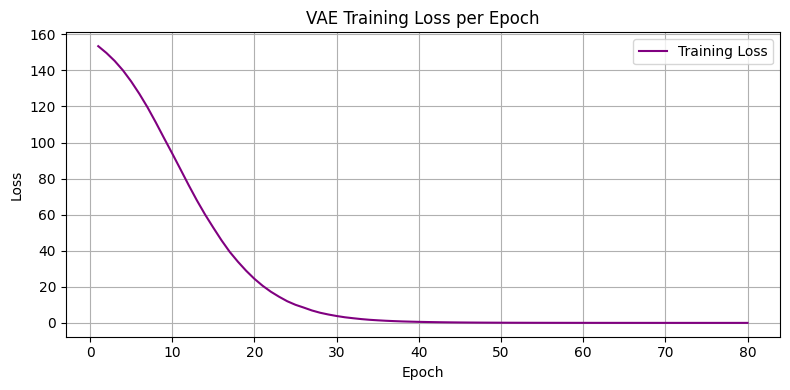

In [9]:
# Graficar pérdida por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), loss_per_epoch, label="Training Loss", color='purple')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Poner el modelo en modo evaluación: desactiva Dropout y BatchNorm (si los hubiera)
vae.eval()

# Bloque donde no se calculan gradientes (acelera la ejecución y reduce memoria)
with torch.no_grad():
    # Creamos 10 vectores aleatorios en el espacio latente, tamaño (10, latent_dim)
    # Esto simula "ideas" de imágenes codificadas
    z = torch.randn(10, latent_dim).to(device)

    # Pasamos los vectores aleatorios por el decoder para generar imágenes
    generated_images = vae.decoder(z).cpu()  # lo pasamos a CPU para visualizar
    
print(generated_images.min(), generated_images.max())


tensor(4.1655e-07) tensor(0.0832)


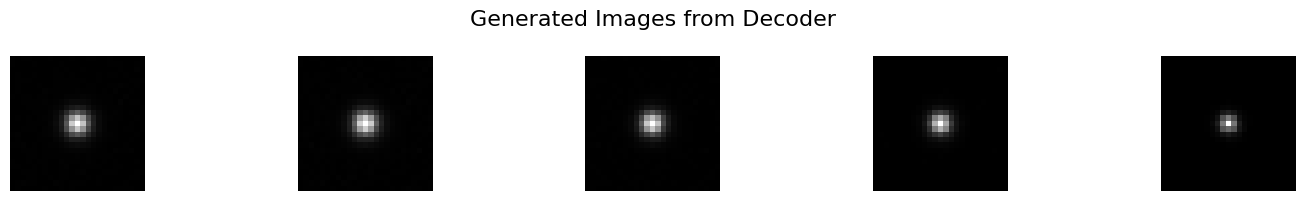

In [11]:
# Poner el modelo en modo evaluación: desactiva Dropout y BatchNorm (si los hubiera)
vae.eval()

# Bloque donde no se calculan gradientes (acelera la ejecución y reduce memoria)
with torch.no_grad():
    # Creamos 10 vectores aleatorios en el espacio latente, tamaño (10, latent_dim)
    # Esto simula "ideas" de imágenes codificadas
    z = torch.randn(10, latent_dim).to(device)

    # Pasamos los vectores aleatorios por el decoder para generar imágenes
    generated_images = vae.decoder(z).cpu()  # lo pasamos a CPU para visualizar

    # Aseguramos que los valores de píxeles estén entre 0 y 1
    generated_images = torch.clamp(generated_images, 0.0, 1.0)

# Visualizamos algunas de las imágenes generadas
n = 5  # Número de imágenes que queremos mostrar
plt.figure(figsize=(15, 2))  # Tamaño de la figura general

for i in range(n):
    ax = plt.subplot(1, n, i + 1)  # Creamos una subfigura (1 fila, n columnas)
    
    # Mostramos la i-ésima imagen, accediendo al canal [0] porque son grises (1 canal)
    plt.imshow(generated_images[i, 0], cmap="gray")
    
    # Ocultamos ejes
    plt.axis("off")

# Título general de la figura
plt.suptitle("Generated Images from Decoder", fontsize=16)

# Ajusta el espaciado entre las imágenes
plt.tight_layout()

# Muestra el gráfico
plt.show()





In [12]:
# Ponemos el modelo en modo evaluación para desactivar dropout y batchnorm (si existieran)
vae.eval()

# Tomamos un batch (lote) de imágenes del DataLoader
noisy_imgs, target_imgs = next(iter(train_loader))  # Puede ser con o sin ruido, según como creaste el loader

# Enviamos los datos al mismo dispositivo del modelo (CPU o GPU)
noisy_imgs = noisy_imgs.to(device)
target_imgs = target_imgs.to(device)

# Desactivamos el cálculo de gradientes (no vamos a entrenar)
with torch.no_grad():
    # Pasamos las imágenes por el modelo para obtener las reconstrucciones
    x_hat, mu, logvar = vae(noisy_imgs)
    # Limitamos los valores de salida entre 0 y 1 para que sean válidos como imagen
    x_hat = torch.clamp(x_hat, 0.0, 1.0)



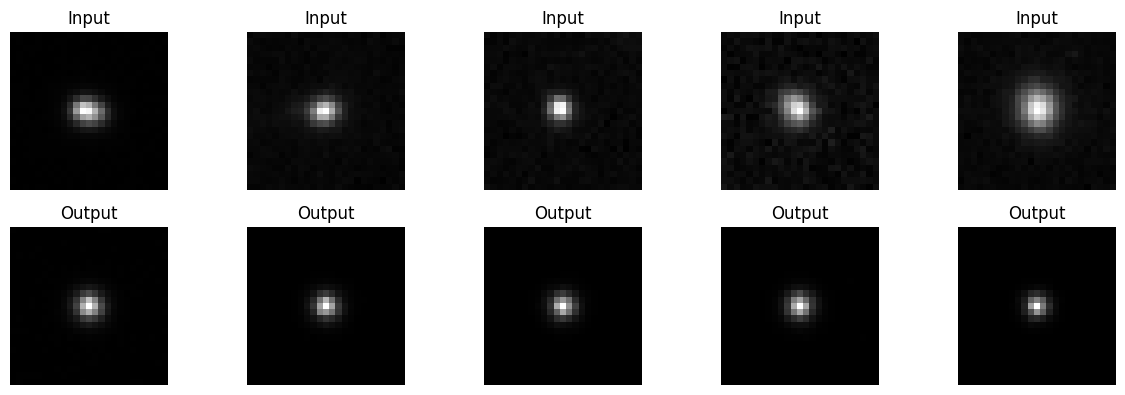

In [13]:
# Visualizamos los primeros 3 ejemplos del batch
n = 5
plt.figure(figsize=(12, 6))

for i in range(n):
    # -------------------
    # Fila 1: Imagen de entrada (posiblemente con ruido)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(noisy_imgs[i, 0].cpu(), cmap="gray")  # Seleccionamos la imagen i y su único canal
    ax.set_title("Input")
    plt.axis("off")

    # -------------------
    # Fila 2: Imagen reconstruida por el VAE (salida del decoder)
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_hat[i, 0].cpu(), cmap="gray")
    ax.set_title("Output")
    plt.axis("off")

# Ajustamos automáticamente los espacios entre subplots para que no se sobrepongan
plt.tight_layout()
plt.show()
